In [1]:
!pip install kaggle

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "ujjwalbhatnagar" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
!kaggle datasets download -d nasa/kepler-exoplanet-search-results

  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 70.2MB/s]


In [3]:
!ls

kepler-exoplanet-search-results.zip  sample_data


In [4]:
import zipfile
zip_ref = zipfile.ZipFile("kepler-exoplanet-search-results.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

In [5]:
import pandas as pd
df=pd.read_csv("/content/files/cumulative.csv")

In [6]:
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [8]:
print('Number of rows and columns in train data:{}' .format(df.shape))

Number of rows and columns in train data:(9564, 50)


In [9]:
#Tokenizing text with scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df)
X_train_counts.shape

(50, 50)

In [10]:
df.describe()

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9564.000000,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,9564.000000,9110.000000,9110.000000,9201.000000,9110.000000,9110.000000,9564.000000,9110.000000,9110.000000,9.201000e+03,9110.000000,9110.000000,9201.000000,9201.000000,9201.000000,9201.000000,0.0,0.0,9.243000e+03,9.243000e+03,9.243000e+03,9201.000000,9218.000000,9201.000000,9096.000000,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,4782.500000,7.690628e+06,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,166.183251,0.009933,-0.009933,0.735105,1.959861,-0.332557,5.621606,0.339942,-0.339942,2.379134e+04,123.197563,-123.197563,102.891778,17.657684,-33.023314,1085.385828,NaN,NaN,7.745737e+03,3.750698e+03,-4.043522e+03,259.895001,1.243654,5706.823280,144.635554,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2761.033321,2.653459e+06,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,67.918960,0.023097,0.023097,3.348832,9.421653,1.249828,6.471554,0.669823,0.669823,8.224268e+04,4112.615230,4112.615230,3077.639126,391.138501,1193.519910,856.351161,NaN,NaN,1.592047e+05,5.504421e+04,8.838831e+04,795.806615,0.664573,796.857947,47.052305,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,120.515914,0.000009,-0.569000,0.000000,0.000000,-59.320000,0.052000,0.000000,-20.200000,0.000000e+00,0.000000,-388600.000000,0.080000,0.000000,-77180.000000,25.000000,NaN,NaN,0.000000e+00,0.000000e+00,-5.600031e+06,0.000000,1.000000,2661.000000,0.000000,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,2391.750000,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,132.761718,0.001240,-0.010500,0.197000,0.040000,-0.445000,2.437750,0.050800,-0.350000,1.599000e+02,9.600000,-49.500000,1.400000,0.230000,-1.940000,539.000000,NaN,NaN,2.015000e+01,9.190000e+00,-2.873100e+02,12.000000,1.000000,5310.000000,106.000000,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,4782.500000,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,137.224595,0.004130,-0.004130,0.537000,0.193000,-0.207000,3.792600,0.142000,-0.142000,4.211000e+02,20.750000,-20.750000,2.390000,0.520000,-0.300000,878.000000,NaN,NaN,1.416000e+02,7.283000e+01,-4.026000e+01,23.000000,1.000000,5767.000000,157.000000,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,7173.250000,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,170.694603,0.010500,-0.001240,0.889000,0.378000,-0.046000,6.276500,0.350000,-0.050800,1.473400e+03,49.500000,-9.600000,14.930000,2.320000,-0.140000,1379.000000,NaN,NaN,8.702900e+02,5.194150e+02,-5.160000e+00,78.000000,1.000000,6112.000000,174.000000,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,9564.000000,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,1472.522306,0.569000,-0.000009,100.806000,85.540000,0.000000,138.5400

In [11]:
type_sum = df.groupby(['kepler_name']).count()
type_sum.sort_values('koi_score', ascending=False, inplace=True)
type_sum

,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
kepler_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Kepler-1 b,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Kepler-415 b,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Kepler-410 A b,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Kepler-411 b,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Kepler-411 c,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kepler-9 d,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1
Kepler-1630 b,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Kepler-279 d,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(50, 50)

In [13]:
df["half"] = df["koi_score"] > 0.5
df["half"].value_counts()

False    5646
True     3918
Name: half, dtype: int64

In [14]:
df.loc[df['koi_score'].isna(), 'koi_score'] = 0
df['kepler_name'] = df['kepler_name'].astype('category')


In [15]:
from sklearn.model_selection import train_test_split
X = df[["koi_score"]]
y = df["half"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [16]:
from sklearn.tree import DecisionTreeClassifier
autoDT = DecisionTreeClassifier(random_state=0, max_depth=3)
autoDT.fit(X_train, y_train)
pred_y = autoDT.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_y, labels=[False, True])
pd.DataFrame(cm, index=["False", "True"], columns=["False", "True"])

,False,True
False,1137,0
True,0,776


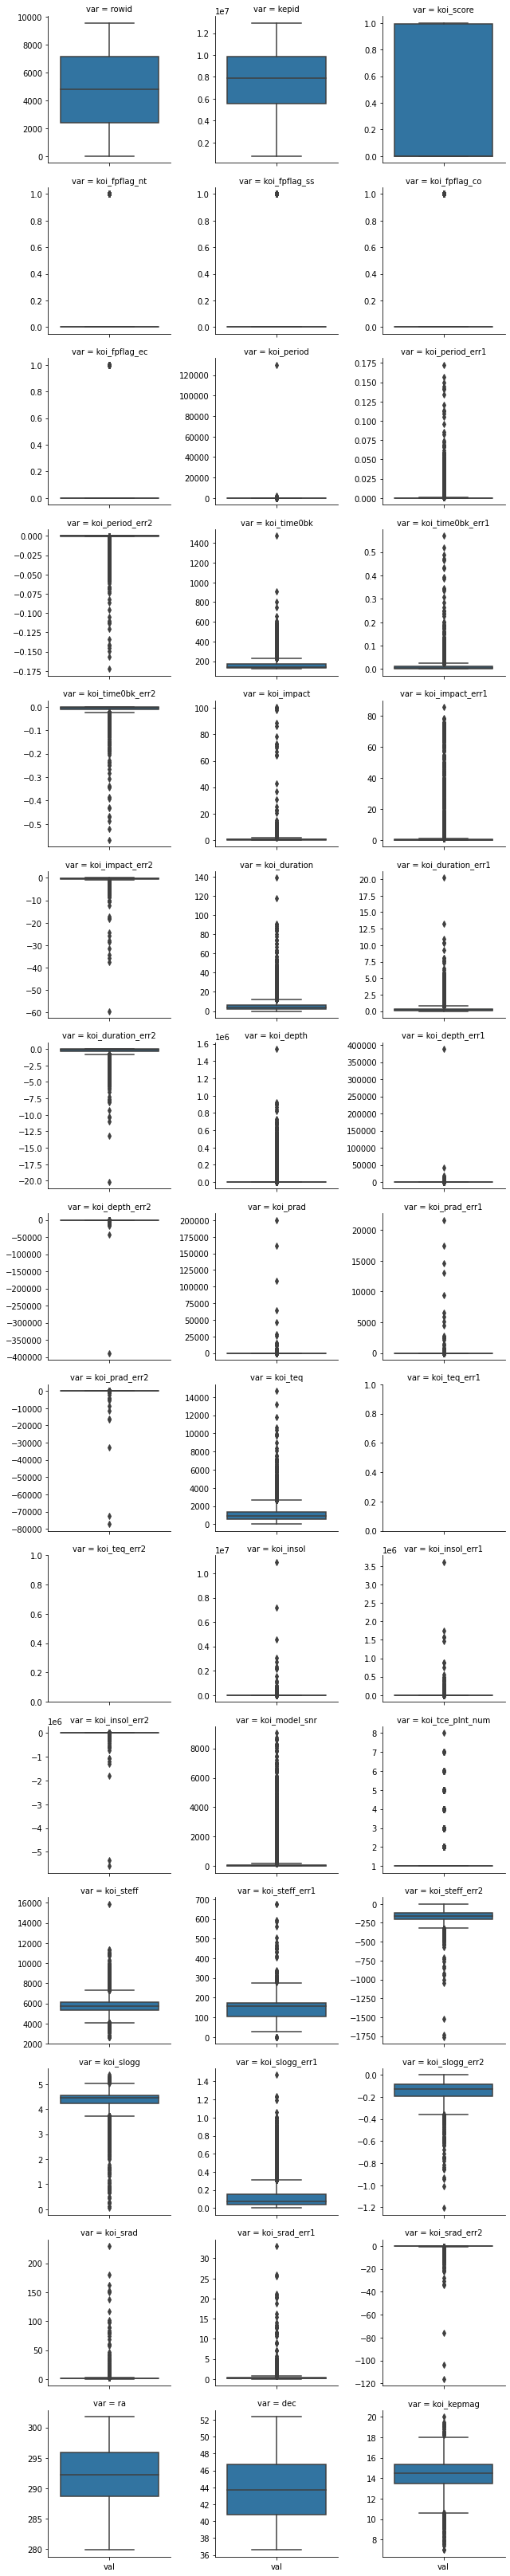

In [18]:
numerics = ['int64', 'float64']
newdf = df.select_dtypes(include=numerics)
newdf = newdf.melt(var_name='var', value_name='val')
import seaborn as sns
sns.catplot(data=newdf, kind='box', height=3, col='var', col_wrap=3, sharey=False);

In [19]:
origin = df["kepler_name"].copy()
origin.cat.categories = range(len(origin.cat.categories))
origin.head()

0    1035
1    1036
2     NaN
3     NaN
4    1867
Name: kepler_name, dtype: category
Categories (2294, int64): [0, 1, 2, 3, ..., 2290, 2291, 2292, 2293]

In [20]:
from sklearn.impute import SimpleImputer
import numpy as np
si = SimpleImputer(missing_values=np.nan, strategy='median')
df["half"] = si.fit_transform(df["half"].values.reshape(-1,1))
df["koi_duration"] = si.fit_transform(df["koi_duration"].values.reshape(-1,1))
df["koi_depth"] = si.fit_transform(df["koi_depth"].values.reshape(-1,1))
df["koi_slogg"] = si.fit_transform(df["koi_slogg"].values.reshape(-1,1))


In [21]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

X = df[["koi_duration", "koi_depth", "koi_slogg"]]
y = df["half"]
dt.fit(X, y)
pd.Series(dt.feature_importances_, index=["koi_duration", "koi_depth", "koi_slogg"]).sort_values(ascending=False)

koi_depth       0.397488
koi_duration    0.322619
koi_slogg       0.279893
dtype: float64

In [22]:
from sklearn.model_selection import train_test_split
X =df[["koi_duration", "koi_depth", "koi_slogg"]]
y = df["half"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
from sklearn.tree import DecisionTreeClassifier
autoDT = DecisionTreeClassifier(random_state=0, max_depth=3)

autoDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [23]:
autoDT2 = DecisionTreeClassifier(max_depth=1, random_state=0)
autoDT2.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [24]:
from sklearn import metrics
pred_test = autoDT.predict(X_test)
pred_test[1:10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1.])

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_y, labels=[False, True])
pd.DataFrame(cm, index=["False", "True"], columns=["False", "True"])

,False,True
False,1137,0
True,0,776


In [26]:
from sklearn.metrics import recall_score, precision_score
(recall_score(y_test, pred_y), precision_score(y_test, pred_y))

(1.0, 1.0)

In [30]:
from sklearn.ensemble import RandomForestClassifier

y = df["half"]

features = ["koi_duration", "koi_depth", "koi_slogg"]
X = pd.get_dummies(df[features])
X_test = pd.get_dummies(df[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'kepid': df.kepid, 'half': predictions})
output.to_csv('submission.csv', index=False)
print("done")

done
